# Basic KLIP Tutorial (using GPI data)

In this notebook, we will do a basic KLIP tutorial using Gemini Planet Imager (GPI) Public Data on β Pic. This tutorial is meant to give you a tutorial on using pyKLIP to perform PSF subtraction with the KLIP algoirthm. It is also meant to give you a brief tutorial on how to use pyKLIP on GPI data, but the steps to perform PSF subtraction should be applicable to using pyKLIP on data from other instruments too. 

This example notebook follows the [Basic KLIP Tutorial](http://localhost:63342/pyklip/docs/build/html/klip_gpi.html) from the pyKLIP docs.

In [12]:
# imports
import glob
import matplotlib.pylab as plt
%matplotlib inline
import IPython.html.widgets as widgets

import numpy as np
import astropy.io.fits as fits
import pyklip.parallelized as parallelized
import pyklip.instruments.GPI as GPI

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Reading in GPI Data

### Acquiring GPI Data

First new need to get our hands on some GPI data. In this notebook, we will use the GPI datacubes used in the testing scripts. They are 3 spectral datacubes from the public release data on β Pic. You can replace this with your own data if you'd like.

In [2]:
filelist = glob.glob("../tests/data/S20131210*distorcorr.fits")
filelist.sort()

print(filelist)

['../tests/data/S20131210S0111_spdc_distorcorr.fits', '../tests/data/S20131210S0092_spdc_distorcorr.fits', '../tests/data/S20131210S0099_spdc_distorcorr.fits']


### Reading in the Data

pyKLIP has interfaces for each instrument that standardizes the data so that they can all be run through the same pyKLIP code. Here, we pass the data into the `pyklip.instruments.GPI.GPIData()` which produces a standardized `dataset` to be processed with pyKLIP. 

NOTE: when reading in the GPI data, the data gets automatically high-pass filtered! If you are reducing extended objects like disks, you will want to avoid this.

In [3]:
dataset = GPI.GPIData(filelist)

Reading File: ../tests/data/S20131210S0111_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0092_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0099_spdc_distorcorr.fits


### What's in the `dataset` object

You can play around with the fields of the dataset object. They are specified in the [GPIData docstring](http://localhost:63342/pyklip/docs/build/html/pyklip.instruments.html#pyklip.instruments.GPI.GPIData). 

The input datacubes are stored in a 3-D array with a shape of (111, 281, 281). The temporal and spatial dimentions have been collapsed


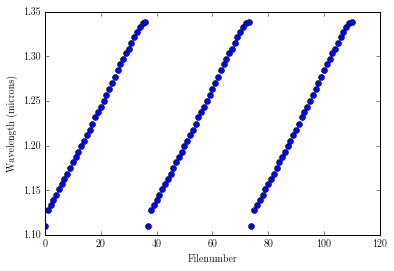

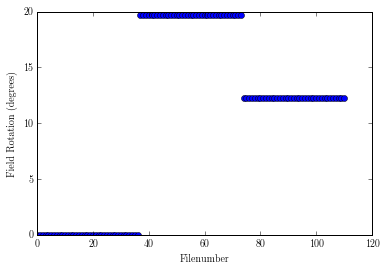

In [8]:
print("The input datacubes are stored in a 3-D array with a shape of {0}. ".format(dataset.input.shape)
      + "The temporal and spatial dimentions have been collapsed")

plt.figure()
plt.plot(dataset.wvs, 'bo')
plt.ylabel("Wavelength (microns)")
plt.xlabel("Filenumber")

plt.figure()
plt.plot(dataset.PAs - dataset.PAs[0], 'bo')
plt.ylabel("Field Rotation (degrees)")
plt.xlabel("Filenumber")

## Run KLIP

Now what you've all been waiting for.. time to run PSF subtraction using the KLIP algorithm. Please read the Basic KLIP Tutorial above for a in-depth explaination of how to tweak the parameters

In [9]:
outputdir = "." # we are going to save the files in the same directory
prefix = "pyklip-betpic-j-131210-k100a9s4m1" # a file prefix to summarize this reduction


parallelized.klip_dataset(dataset, outputdir=outputdir, fileprefix=prefix,
                          annuli=9, subsections=4, movement=1, numbasis=[1,20,50,100],
                          calibrate_flux=True, mode="ADI+SDI")

Beginning ADI+SDI KLIP
Begin align and scale images for each wavelength
Wavelength 1.139 with index 3 has finished align and scale. Queuing for KLIP
Wavelength 1.11 with index 0 has finished align and scale. Queuing for KLIP
Wavelength 1.133 with index 2 has finished align and scale. Queuing for KLIP
Wavelength 1.128 with index 1 has finished align and scale. Queuing for KLIP
Wavelength 1.157 with index 6 has finished align and scale. Queuing for KLIP
Wavelength 1.163 with index 7 has finished align and scale. Queuing for KLIP
Wavelength 1.145 with index 4 has finished align and scale. Queuing for KLIP
Wavelength 1.151 with index 5 has finished align and scale. Queuing for KLIP
Wavelength 1.169 with index 8 has finished align and scale. Queuing for KLIP
Wavelength 1.174 with index 9 has finished align and scale. Queuing for KLIP
Wavelength 1.187 with index 11 has finished align and scale. Queuing for KLIP
Wavelength 1.181 with index 10 has finished align and scale. Queuing for KLIP
Wav

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


## Output Files

Now that KLIP has finished, it also has rotated the images to be all North up and stacked them in time. Here are now all the output files it creased (provided you didn't chagne the fileprefix or any of the PSF subtraction parameters):

  1. *pyklip-betpic-j-131210-k100a9s4m1-KL1-speccube.fits* : Spectral cube using 1 KL mode to model the stellar PSF
  2. *pyklip-betpic-j-131210-k100a9s4m1-KL20-speccube.fits* : Spectral cube using 20 KL modes
  3. *pyklip-betpic-j-131210-k100a9s4m1-KL50-speccube.fits* : Spectral cube using 50 KL modes
  4. *pyklip-betpic-j-131210-k100a9s4m1-KL100-speccube.fits* : Spectral cube using 100 KL modes
  5. *pyklip-betpic-j-131210-k100a9s4m1-KLmodes-all.fits* : KL mode cube (a cube that is collapsed in time and in wavelength) with the 3rd dimension being the number of KL modes used. This cube specifically has 4 frames, one for each KL cutoff, with increasing KL modes. 

### Spectral Cube

Here is the KL 20 spectral mode datacube as we scroll through the wavelengths

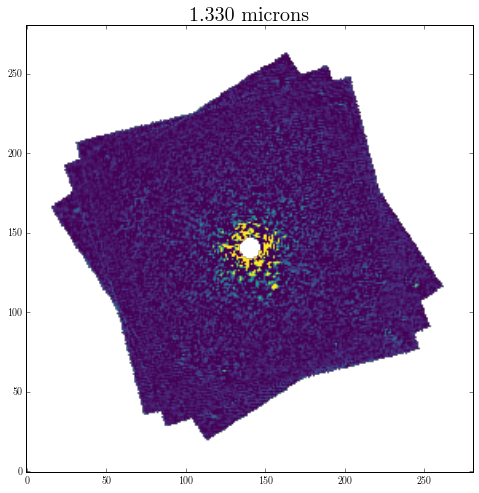

In [30]:
spec_hdulist = fits.open("{out}/{pre}-KL20-speccube.fits".format(out=outputdir, pre=prefix))
speccube_kl20 = spec_hdulist[1].data
specheader_kl20 = spec_hdulist[1].header
print("The dimensions of this datacube is {0}".format(speccube_kl20.shape))

cube_wvs_step = specheader_kl20['CD3_3'] # \Delta \lambda for each wavelength slice of the cube
cube_wvs_min = specheader_kl20['CRVAL3'] # wavelength of slice 0 of the spectral cube
cube_wvs = cube_wvs_min + np.arange(speccube_kl20.shape[0]) * cube_wvs_step #construct the wavelength axis
cube_wvs_max = cube_wvs[-1] # wavelength of last slice of the spectral cube


def pltcube(selected_wv):
    wv_index = np.argmin(np.abs(selected_wv - cube_wvs)) # get the index into the array
    plt.figure(figsize=(8,8))
    plt.imshow(speccube_kl20[wv_index], cmap='viridis', vmin=-5e-7, vmax=1e-5)
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0:.3f} microns".format(selected_wv), fontsize=20)
    plt.show()
    
widgets.interact(pltcube, selected_wv=(cube_wvs_min, cube_wvs_max, cube_wvs_step))

### KL Mode Cube

Now we will scrol through using different KL mode cutoffs in data that has been collapsed in time and wavelength. This allows us visiually get a feel for how many KL modes to use to model the stellar PSF.

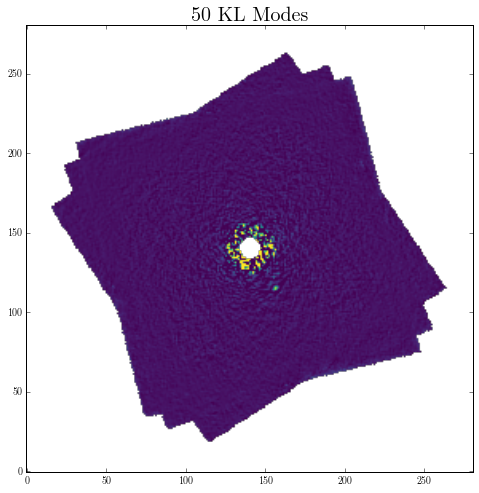

In [29]:
kl_hdulist = fits.open("{out}/{pre}-KLmodes-all.fits".format(out=outputdir, pre=prefix))
klcube = kl_hdulist[1].data
klheader = kl_hdulist[1].header
print("The dimensions of this datacube is {0}".format(speccube_kl50.shape))

num_cutoffs = klcube.shape[0] # number of KL mode cutoffs saved
kl_cutoffs = [klheader['KLMODE{0}'.format(cutoff_i)] for cutoff_i in range(num_cutoffs) ] # grab all the KL mode cutoffs from the header

def pltcube(selected_kl_index):
    plt.figure(figsize=(8,8))
    plt.imshow(klcube[selected_kl_index], cmap='viridis', vmin=-5e-7, vmax=1e-5)
    plt.gca().invert_yaxis() # flip the y axis so that [0,0] is in the bottom left corner. 
    plt.title("{0} KL Modes".format(kl_cutoffs[selected_kl_index]), fontsize=20)
    plt.show()
    
widgets.interact(pltcube, selected_kl_index=(0, num_cutoffs-1, 1))